In [65]:
# Import DS Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch import nn
import torch

from tqdm import trange

from google.colab import drive
drive.mount('/drive')
%cd "/drive/MyDrive/"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive


# **Read In Data**

In [30]:
aggie_data = pd.read_excel('clean_data.xlsx')
aggie_data = aggie_data.drop("timestamp", axis = 1)
aggie_data.head()

,two_percenter,major,experience_coding,statistics_knowldege,age,number_of_yells,football_games,basketball_games,volleyball_games,baseball_games,...,video_games,sports,working_out,reading,cooking,dancing,singing,shows_movies_anime,outdoors,photography
0,No,engr,2.000000,5,19.0,2,2,4,0,1,...,True,True,False,False,False,False,True,False,False,False
1,Yes,cpsc,2.541667,8,19.0,6,10,0,0,0,...,True,True,False,False,False,False,False,False,False,False
2,Yes,cpsc,2.541667,5,19.0,0,1,0,0,0,...,True,False,False,False,True,False,False,True,False,False
3,Yes,stat,3.000000,10,22.0,0,0,0,0,0,...,True,False,False,False,True,False,False,True,True,True
4,No,cpsc,4.000000,5,20.0,1,3,0,0,0,...,False,False,True,False,True,False,False,False,False,True


In [31]:
aggie_data.select_dtypes(include=['bool']).columns.tolist()

['video_games',
 'sports',
 'working_out',
 'reading',
 'cooking',
 'dancing',
 'singing',
 'shows_movies_anime',
 'outdoors',
 'photography']

In [35]:
aggie_data.dtypes

two_percenter            object
major                    object
experience_coding       float64
statistics_knowldege      int64
age                     float64
number_of_yells           int64
football_games            int64
basketball_games          int64
volleyball_games          int64
baseball_games            int64
aggie_ring               object
hours_studying            int64
times_at_bigevent         int64
study_abroad             object
bedtime                  object
hours_sleeping            int64
homebody_or_goingout     object
extrovert_introvert      object
siblings                  int64
plan_on_masters          object
location                 object
video_games               int64
sports                    int64
working_out               int64
reading                   int64
cooking                   int64
dancing                   int64
singing                   int64
shows_movies_anime        int64
outdoors                  int64
photography               int64
dtype: o

In [40]:
aggie_data_new['bedtime'].values[2]

datetime.time(23, 0)

### Feature Engineer for PyTorch

In [41]:
def one_hot_encode_bools(X):
    """
    DESCRIPTION:
      One hot encodes boolean features.
    INPUT:
      X: pd DataFrame to one hot encode boolean dtype columns.
    OUTPUT:
      X: pd DataFrame with one hot encoded columns.
    """
    # List of column names for string features to one hot encode
    bool_cols = X.select_dtypes(include=['bool']).columns.tolist()

    # Encode with the replace function
    X[bool_cols] = X[bool_cols].replace({True: 1, False: 0})
    return X

def one_hot_encode(X):
    """
    DESCRIPTION:
      One hot encodes string features in a pd DataFrame using sklearn's OneHotEncoder.
    INPUT:
      X: pd DataFrame to one hot encode.
    OUTPUT:
      X: pd DataFrame with one hot encoded columns.
    """
    # List of column names for string features to one hot encode
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    X[cat_cols] = X[cat_cols].astype(str) # Coerce to strings since some read in as time objects

    # Encoder
    encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
    encoded_cols = encoder.fit_transform(X[cat_cols])
    feature_names = encoder.get_feature_names_out(cat_cols)
    encoded_X = pd.DataFrame(encoded_cols, columns = feature_names)
    encoded_X = encoded_X.reset_index(drop = True)  # reset index to avoid duplicate index
    X = X.reset_index(drop = True)  # reset index to avoid duplicate index

    # Add to original dataframe
    X = pd.concat([X.drop(cat_cols, axis=1), encoded_X], axis=1)
    return X

In [42]:
aggie_data_new = one_hot_encode_bools(aggie_data)
aggie_data_new = one_hot_encode(aggie_data_new)
aggie_data_new.columns

Index(['experience_coding', 'statistics_knowldege', 'age', 'number_of_yells',
       'football_games', 'basketball_games', 'volleyball_games',
       'baseball_games', 'hours_studying', 'times_at_bigevent',
       'hours_sleeping', 'siblings', 'video_games', 'sports', 'working_out',
       'reading', 'cooking', 'dancing', 'singing', 'shows_movies_anime',
       'outdoors', 'photography', 'two_percenter_No', 'two_percenter_Yes',
       'major_apmt', 'major_biol', 'major_bmen', 'major_busn', 'major_cecn',
       'major_chen', 'major_comp', 'major_cpcs', 'major_cpsc', 'major_daen',
       'major_ehgr', 'major_elen', 'major_engr', 'major_finc', 'major_fivs',
       'major_gist', 'major_isen', 'major_laup', 'major_math', 'major_mbio',
       'major_meen', 'major_mktg', 'major_nrsc', 'major_phys', 'major_stat',
       'major_urpn', 'major_wgst', 'aggie_ring_Maybe', 'aggie_ring_No',
       'aggie_ring_Yes', 'study_abroad_No', 'study_abroad_Yes',
       'bedtime_00:00:00', 'bedtime_21:00:00', 

In [55]:
aggie_data_new.info() # Last check for all numeric data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 91 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   experience_coding                50 non-null     float64
 1   statistics_knowldege             50 non-null     int64  
 2   age                              50 non-null     float64
 3   number_of_yells                  50 non-null     int64  
 4   football_games                   50 non-null     int64  
 5   basketball_games                 50 non-null     int64  
 6   volleyball_games                 50 non-null     int64  
 7   baseball_games                   50 non-null     int64  
 8   hours_studying                   50 non-null     int64  
 9   times_at_bigevent                50 non-null     int64  
 10  hours_sleeping                   50 non-null     int64  
 11  siblings                         50 non-null     int64  
 12  video_games             

### Train-valid-test split

In [45]:
target = ['aggie_ring_Maybe', 'aggie_ring_No', 'aggie_ring_Yes']
y = aggie_data_new[target]
X = aggie_data_new.drop(target, axis = 1)

In [136]:
# Train-test split: 80-10-10

### Train 80%
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 42)
### Test and valid
X_valid, X_test, y_valid, y_test = train_test_split(X_holdout, y_holdout, test_size = 0.5, random_state = 42)

X_train = torch.tensor(X_train.values).float()
X_valid = torch.tensor(X_valid.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).int()
y_valid = torch.tensor(y_valid.values).int()
y_test = torch.tensor(y_test.values).int()

In [137]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([40, 88]), torch.Size([5, 88]), torch.Size([5, 88]))

In [138]:
X_valid

tensor([[ 0.,  3., 19.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  8.,  1.,  0.,  0.,
          1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  8., 19.,  0.,  2.,  0.,  0.,  0.,  5.,  0.,  8.,  1.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.

In [139]:
y_train.shape, y_valid.shape, y_test.shape

(torch.Size([40, 3]), torch.Size([5, 3]), torch.Size([5, 3]))

In [140]:
aggie_data['aggie_ring'].value_counts() # Imbalanced problem

aggie_ring
Yes      42
Maybe     7
No        1
Name: count, dtype: int64

# **Model**

### Model Creation

In [141]:
class LogisticRegression(torch.nn.Module):
    # Instantiate the model
    def __init__(self, in_channels, hidden_1, hidden_2, out_channels):
        super(LogisticRegression, self).__init__()
        # Layers
        self.layer1 = torch.nn.Linear(in_channels, hidden_1)
        self.layer2 = torch.nn.Linear(hidden_1, hidden_2)
        self.layer3 = torch.nn.Linear(hidden_2, hidden_1)
        self.layer4 = torch.nn.Linear(hidden_1, out_channels)
        # Activation
        self.relu = nn.ReLU()
        # Bring real numbers to 0-1 probabilities
        self.softmax = nn.Softmax(dim = 1)
        # Regularization to help prevent overfitting
        self.drop = nn.Dropout(0.3) # Drop 30% of neurons

    def forward(self, x):
        x = self.layer1(x) # in_channels => hidden_1
        x = self.relu(x)
        x = self.layer2(x) # hidden_1 => hidden_2
        x = self.relu(x)
        x = self.drop(x) # drop out
        x = self.layer3(x) # hidden_2 => hidden_1
        x = self.relu(x)
        x = self.layer4(x) # hidden_1 => out_channels (class size)
        probs = self.softmax(x) # now bounded between 0 and 1
        return probs

### Model Training

In [146]:
# Instantiate the model and optimizer
model = LogisticRegression(X_train.shape[1], 128, 256, 3) # (Number of features), #, #, (number of predicted classes)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Define our loss function
def ce_loss(model, x, y):
    p = model(x)
    return -torch.mean(torch.log(p) * y)

loss_func = ce_loss

In [147]:
# Train
epochs = 1000
train_loss = []
valid_loss = []
acc = []

for i in trange(epochs):
  loss = ce_loss(model, X_train, y_train)
  loss.backward()

  train_loss.append(loss.detach().numpy())
  valid_loss.append(ce_loss(model, X_valid, y_valid).detach().numpy())

  optimizer.step()
  optimizer.zero_grad()

100%|██████████| 1000/1000 [00:03<00:00, 307.79it/s]


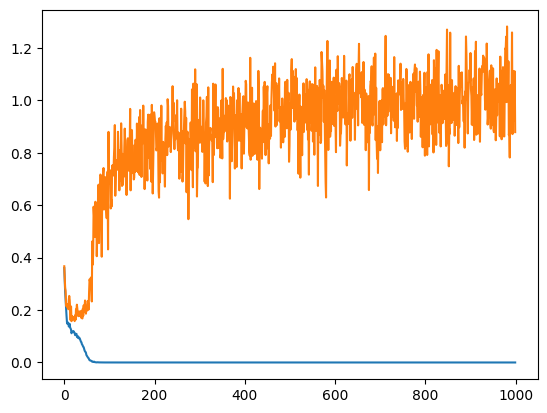

In [148]:
# Plot loss
plt.plot(train_loss) # Blue
plt.plot(valid_loss) # orange

Lots of overfitting! Let's regularize or stop early

### Stopping early manually around 25 epochs

In [156]:
# Instantiate the model and optimizer
model = LogisticRegression(X_train.shape[1], 128, 256, 3) # (Number of features), #, #, (number of predicted classes)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# Define our loss function
def ce_loss(model, x, y):
    p = model(x)
    return -torch.mean(torch.log(p) * y)

loss_func = ce_loss

In [157]:
# Train
epochs = 25
train_loss = []
valid_loss = []
acc = []

for i in trange(epochs):
  loss = ce_loss(model, X_train, y_train)
  loss.backward()

  train_loss.append(loss.detach().numpy())
  valid_loss.append(ce_loss(model, X_valid, y_valid).detach().numpy())

  optimizer.step()
  optimizer.zero_grad()

100%|██████████| 25/25 [00:00<00:00, 282.22it/s]


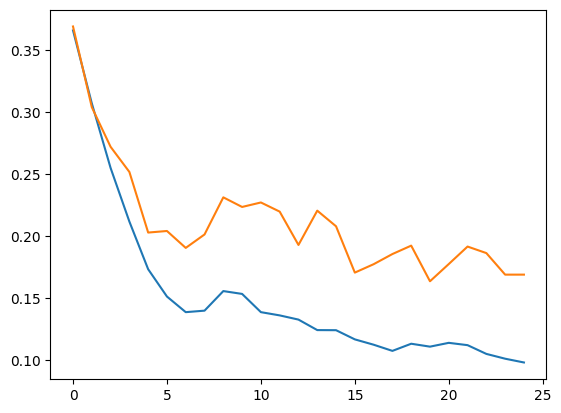

In [158]:
# Plot loss
plt.plot(train_loss) # Blue
plt.plot(valid_loss) # orange

Great!

# **Test Set and Results**

In [160]:
probs_test = model(X_test).detach().numpy()
# Choose largest prob for each person in the test set
yhat_test = np.argmax(probs_test, axis = 1)

In [162]:
probs_test

array([[1.0488728e-01, 2.9333930e-03, 8.9217931e-01],
       [8.5540839e-02, 1.6181596e-03, 9.1284102e-01],
       [7.3719040e-02, 8.2032668e-04, 9.2546058e-01],
       [8.6475179e-02, 3.6142243e-03, 9.0991062e-01],
       [8.5931122e-02, 1.9130075e-03, 9.1215593e-01]], dtype=float32)

In [161]:
yhat_test

array([2, 2, 2, 2, 2])

In [163]:
# In reality
np.argmax(y_test, axis = 1)

tensor([2, 2, 2, 1, 0])

In [165]:
# ['aggie_ring_Maybe', 'aggie_ring_No', 'aggie_ring_Yes'] => [0, 1, 2] labels

In [164]:
aggie_data['aggie_ring'].value_counts() # Imbalanced problem, hard to get right without weighting in loss function or getting more data

aggie_ring
Yes      42
Maybe     7
No        1
Name: count, dtype: int64